# Matrix Factorization

<b>User-based</b> and <b>Item-based</b> collaborative Filtering recommender systems suffer from <i>data sparsity</i> and <i>scalability</i> for online recommendations. <b>Matrix Factorization</b> helps to address these drawbacks of memory-based collaborative filtering by reducing the dimension of the rating matrix $R$.

The movielen lasted small dataset has 100k ratings of $m=610$ users on $n=9724$ items. The rating matrix in then a $m\times n$ matrix (i.e $R\in \mathbb{R}^{m\times n}$). The fact that users usually interact with less than $1\%$ of items leads the rating matrix $R$ to be highly sparse. For example, the degree of sparsity of the movielen lasted small dataset is 

\begin{equation}
sparsity = 100 - \frac{\text{total # ratings}}{m \times n} = 100 - \frac{100000}{610\times 9724} = 98,3\%
\end{equation}

This means that in this dataset, a user has interacted with less than $2\%$ of items. To reduce the dimension of the rating matrix $R$, Matrix Factorization (MF) mappes both users and items to a joint latent factor space of dimensionality $k$ such that user-item interactions are modeled as inner products in that space <a href='https://ieeexplore.ieee.org/document/5197422'>(Yehuda Koren et al., 2009)</a>. MF then decomposes $R$ in two matrices as follows :

\begin{equation}
R = Q^\top P
\end{equation}

Where $P \in \mathbb{R}^{m\times k}$ represents latent factors of users and $Q \in \mathbb{R}^{n\times k}$ is the latent factors of items. Each line of $P$, say $p_u \in \mathbb{R}^k$ denotes the taste of user $u$ and each $q_i \in \mathbb{R}^k$ the features of item $i$. The dot product between $p_u$ and $q_i$ will be the rating prediction of user $u$ on item $i$ :

\begin{equation}
\hat{r}_{u,i} = q_{i}^{\top} p_u.
\end{equation}

Figure 1 presents an example of decomposition of $R$ into two matrices $P$ and $Q$.

<img src="tools/img/MF.png" width="650px">
<br>
<center><b>Figure 1</b>: Decomposition of $R$ into $P$ and $Q$</center>


To learn the latent factors $p_u$ and $q_i$, the system minimizes the regularized squared error on the set of known ratings. The cost function $J$ is defined as follows : 

\begin{equation}
J = \frac{1}{2}\sum_{(u,i)\in \kappa} (r_{ui} - q_{i}^{\top} p_u)^2 + \lambda(||p_u||^2 + ||q_i||^2)
\end{equation}

where $\kappa$ is the set of $(u,i)$ pairs for which $r_{u,i}$ is known (the training set), and $\lambda$ is the regularizer parameter.

## Learning Algorithms

As described in <a href='https://ieeexplore.ieee.org/document/5197422'>(Yehuda Koren et al., 2009)</a>, to minimize the cost function $J$, the matrix factorization algorithm predicts $\hat{r}_{u,i}$ for each given training case (existing $r_{u,i}$), and computes the associated error defined by the Mean Absolute Error (MAE) as :

\begin{equation}
e_{u,i} = |r_{ui} - q_{i}^{\top} p_u|.
\end{equation}

<b>Note</b> : The overall error $E$ is defined as :

\begin{equation}
E = \frac{1}{M}\sum_{(u,i)\in\kappa} e_{u,i}
\end{equation}

Where $M$ is the number of example. The update rules for parameters $p_u$ and $q_i$ are defined as follows :

\begin{equation}
q_i \leftarrow q_i - \alpha\frac{\partial}{\partial q_i}J_{u,i}, 
\end{equation}

\begin{equation}
p_u \leftarrow p_u - \alpha\frac{\partial}{\partial p_u}J_{u,i}
\end{equation}

where $\alpha$ is the learning rate and $\frac{\partial}{\partial p_u}J_{u,i}$ is the partial derivative of the cost function $J$ according to $p_u$. It computes the extent to which $p_u$ contributes to the total error.

### How to compute $\frac{\partial}{\partial q_i}J_{u,i}$ ?

\begin{align}
\frac{\partial}{\partial q_i}J_{u,i} & = & \frac{1}{2}\frac{\partial}{\partial q_i} \begin{bmatrix}(r_{ui} - q_{i}^{\top} p_u)^2 + \lambda(||p_u||^2 + ||q_i||^2)\end{bmatrix} \\
& = & -(r_{u,i}-q_{i}^{\top} p_u)\cdot p_u + \lambda \cdot q_i  \\
& = & -e_{u,i}\cdot p_u+\lambda \cdot q_i
\end{align}

The update rules are then given by : 

\begin{equation}
q_i \leftarrow q_i + \alpha\cdot (e_{u,i}\cdot p_u-\lambda \cdot q_i), 
\end{equation}

\begin{equation}
p_u \leftarrow p_u + \alpha\cdot (e_{u,i}\cdot q_i-\lambda \cdot p_u)
\end{equation}

## Matrix Factorization : algorithm
<ol>
    <li>Initialize $P$ and $Q$ with random values
    <li>For each training example $(u,i)\in\kappa$ with the corresponding rating $r_{u,i}$ :
        <ul>
            <li>compute $\hat{r}_{u,i}$ as $\hat{r}_{u,i} = q_{i}^{\top} p_u$
            <li>compute the error : $e_{u,i} = |r_{ui} - \hat{r}_{u,i}|$
            <li>update $p_u$ and $q_i$:
                <ul>
                    <li>$p_u \leftarrow p_u + \alpha\cdot (e_{u,i}\cdot q_i-\lambda \cdot p_u)$
                    <li>$q_i \leftarrow q_i + \alpha\cdot (e_{u,i}\cdot p_u-\lambda \cdot q_i)$
                </ul>
        </ul>
    <li> Repeat step 2 until the optimal parameters are reached.
</ol>


## Matrix Factorization : implementation

Let's start by importing useful requirements

### Import requirements

In [1]:
from tools.utils import download_data, load_movies, load_ratings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os

Download movielen data if it doesn't exist

In [2]:
data = os.path.join('tools', 'ml-latest-small')

if os.path.exists(data):
    print('Data already exists ...')
    ratings_csv, movies_csv = os.path.join(data, 'ratings.csv'), os.path.join(data, 'movies.csv')
else:
    ratings_csv, movies_csv = download_data()

Data already exists ...


### Loading dataset

In [3]:
ratings, movies = load_ratings(ratings_csv), load_movies(movies_csv)

Let's generate our rating matrix from from the ```ratings``` dataframe

In [4]:
def ratings_matrix(ratings):
    """
    :param ratings : DataFrame of user ratings
    :return R : numpy array of shape (m,n). where m is the number of users and n the number of items
    """
    
    R = csr_matrix(pd.crosstab(ratings.userid, ratings.itemid, ratings.rating, aggfunc=sum).fillna(0).values)
    
    return R

In [5]:
R = ratings_matrix(ratings)
R.shape

(610, 9724)

As expected, the shape of $R$ is (610, 9724). ```R[0,:]``` (resp. ```R[909,:]```) represents ratings given by the first user with id=1 (resp. the last user with id=910) to all items. Similarily, ```R[:,0]``` (resp. ```R[:,9723]```) represents ratings given by all users to the first item with index 0 (resp. to the last items with index 9723).

We have 9724 items, but their ids do not ranges from 1 to 9724 but from 1 to 193609. So our item ids are 9724 values taken in the range 1 to 193609. In order to be able to access ratings of users or items through the rating matrix $R$, we need to encode their ids in such a way that they range from 0 to 909 for users and from 0 to 9723 for items. To do that, we will user the ```LabelEncoder``` of the ```sklearn``` library.

Moreover, we need to split our dataset into train and test sets for training and validation steps respectively.
1. ```examples``` is the set of $(u,i)$ pairs for which $r_{u,i}$ is known.
2. ```labels``` set of existing ratings $r_{u,i}$ for all $(u,i)$ pairs

In [6]:
examples = ratings[['userid', 'itemid']].values
labels = ratings.rating.values

Now let's split our training ```examples``` as well as their ```labels``` into train and validation sets using the ```train_test_split``` function of the ```sklearn``` library. The details about splitting are the following:

- ```test_size = 0.1``` specifies that the size of the test set will account for $10\%$ of the data set and that the training set will take $100\%-10\%=90\%$. 
- With the ```shuffle``` parameter assigned to ```True```, the dataset will be randomly shuffled before the train/test split operation.
- The ```random_state``` controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls

In [7]:
train_examples, test_examples, train_labels, test_labels = train_test_split(
    examples, 
    labels, 
    test_size=0.1, 
    random_state=42, 
    shuffle=True
)

Now let's encode our training and validation examples to be able to access their corresponding latent factors in $P$ and $Q$

In [8]:
users = sorted(ratings['userid'].unique())
items = sorted(ratings['itemid'].unique())

# create our id encoders
uencoder = LabelEncoder()
iencoder = LabelEncoder()

# fit our label encoder
uencoder.fit(users)
iencoder.fit(items)

# transform train and test examples to their corresponding one-hot representations
train_users = train_examples[:,0]
test_users = test_examples[:,0]

train_items = train_examples[:,1]
test_items = test_examples[:,1]

train_users = uencoder.transform(train_users)
test_users = uencoder.transform(test_users)

train_items = iencoder.transform(train_items)
test_items = iencoder.transform(test_items)

Final training and test sets

In [9]:
X_train, X_test = np.array(list(zip(train_users, train_items))), np.array(list(zip(test_users, test_items)))
y_train, y_test = train_labels, test_labels

In [10]:
m = ratings['userid'].nunique()   # total number of users
n = ratings['itemid'].nunique()   # total number of items

print('number of users : ', m)
print('number of items : ', n)

number of users :  610
number of items :  9724


### Matrix Factorization Model

Now let's define our matrix factorization model. Here are the methods associated to our matrix factorization model

1. ```fit(x_train, y_train, epochs, validation_data)```: train the matrix factorization model (train the latent factors $P$ and $Q$) on the training set for 1000 epochs by default and use the test set as validation data.
2. ```evaluate(x_test, y_test)```: evaluate the model on the test set
3. ```predict(userid, itemid)```: make rating prediction for a user on a given item using the learnt latent factors $P$ and $Q$.
4. ```recommend(userid, N=30)```: make top $N$ recommendation for a given user. Return the top $N$ items with the $N$ largest predicted ratings.

In [11]:
class MatrixFactorization:
    
    def __init__(self, R, m, n, k=50, alpha=0.1, lamb=1):
        """
        Initialization of the model        
        :param
            - R : rating matrix of shape (m,n)
            - m : number of users
            - n : number of items
            - k : length of latent factor, both for users and items. 50 by default
            - alpha : learning rate. 0.001 by default
            - lamb : regularizer parameter. 0.02 by default
        """
        # rating matrix
        self.R = R
        
        np.random.seed(32)
        
        # initialize the latent factor matrices P and Q (of shapes (m,k) and (n,k) respectively) that will be learnt
        self.k = k
        self.P = np.random.normal(size=(m,k))
        self.Q = np.random.normal(size=(n,k))
        
        # hyperparameter initialization
        self.alpha = alpha
        self.lamb = lamb
        
        # training history
        self.history = {
            "epochs":[],
            "loss":[],
            "val_loss":[]
        }
    
    def fit(self, x_train, y_train, validation_data, epochs=1000):
        """
        Train latent factors P and Q according to the training set
        
        :param
            - x_train : training pairs (u,i) for which rating r_ui is known
            - y_train : set of ratings r_ui for all training pairs (u,i)
            - validation_data : tuple (x_test, y_test)
            - epochs : number of time to loop over the entire training set. 
            1000 epochs by default
            
        Note that u and i are encoded values of userid and itemid
        """
        
        print('[INFO] Training Matrix Factorization with the following hyperparameters :\n')
        print('   - Number of latent factor k = {}'.format(self.k))
        print('   - learning rate alpha = {}'.format(self.alpha))
        print('   - regularization parameter lamb = {} \n'.format(self.lamb))
        print('[INFO] Strating training job ... \n')

        # number of training examples
        M = x_train.shape[0]
        
        # loop over the number of epochs
        for epoch in range(epochs):
            
            # for each pair (u,i) and the corresponding rating r
            for pair, r in zip(x_train, y_train):
                
                # get encoded values of userid and itemid from pair
                u,i = pair
                
                # compute the predicted rating r_hat
                r_hat = np.dot(self.P[u], self.Q[i])
                
                # compute the prediction error
                e = abs(r - r_hat)
                
                # update rules
                # P[u,:] = P[u,:] + alpha * (e * Q[i,:] - lambda * P[u,:])
                self.P[u] = self.P[u] + self.alpha * (e * self.Q[i] - self.lamb * self.P[u])
                self.Q[i] = self.Q[i] + self.alpha * (e * self.P[u] - self.lamb * self.Q[i])
                
            # global training error after this epochs
            error = 0
            for pair, r in zip(x_train, y_train):
                error += abs(r - np.dot(self.P[pair[0]], self.Q[pair[1]]))
            error /= M

            # error on validation set
            x_test, y_test = validation_data
            val_error = 0
            for pair, r in zip(x_test, y_test):
                val_error += abs(r - np.dot(self.P[pair[0]], self.Q[pair[1]]))
            val_error /= x_test.shape[0]
            
            # update history
            self.history['epochs'].append(epoch)
            self.history['loss'].append(error)
            self.history['val_loss'].append(val_error)
            
            # print training progress after each 10 epochs
            if epoch % 5 == 0 or epoch == epochs-1:
                print("epoch {}/{} - loss : {} - val_loss : {}".format(epoch, epochs, round(error,3), round(val_error,3)))
              
            # leaning rate scheduler : redure the learning rate as we go deeper in the number of epochs
            if epoch >= 30 and epoch % 30 == 0:
                factor = epoch // 30
                self.alpha = self.alpha * (1 / (factor * 20))
                print("\nLearning Rate : {}\n".format(self.alpha))
        
        return self.history
    
    def evaluate(self, x_test, y_test):
        """
        compute the global error on the test set
        
        :param
            - x_test : test pairs (u,i) for which rating r_ui is known
            - y_test : set of ratings r_ui for all test pairs (u,i)
        """
        # number of test examples
        M = x_test.shape[0]
        
        # initialize the error
        error = 0
        for pair, r in zip(x_test, y_test):
            u,i = pair
            e = abs(r - np.dot(self.P[u,:], self.Q[i,:]))
            error += e
        
        error /= M
        print("val_error : ", str(round(error,3)))
      
    def predict(self, userid, itemid):
        """
        Make rating prediction for a user on an item

        :param
        - userid
        - itemid

        :return
        - r : predicted rating
        """
        # encode user and item ids to be able to access their latent factors in
        # matrices P and Q
        u = uencoder.transform([userid])[0]
        i = iencoder.transform([itemid])[0]

        # rating prediction using encoded ids. Dot product between P_u and Q_i
        r = np.dot(self.P[u], self.Q[i])

        return r

    def recommend(self, userid, N=30):
        """
        make to N recommendations for a given user

        :return 
        - (top_items,preds) : top N items with the highest predictions 
        with their corresponding predictions
        """
        # encode the userid
        u = uencoder.transform([userid])[0]

        # predictions for users userid on all product
        predictions = np.dot(self.P[u], self.Q.T)

        # get the indices of the top N predictions
        top_idx = np.flip(np.argsort(predictions))[:N]

        # decode indices to get their corresponding itemids
        top_items = iencoder.inverse_transform(top_idx)

        # take corresponding predictions for top N indices
        preds = predictions[top_idx]

        return top_items, preds        

Now that the model has been defined, let's fit it with the training set. The efficiency of the model will highly depends on hyperparameters tuning : find optimal values of $k$ (number of latent factors both for users and items), $\alpha$ (```alpha```, the learning rate) and $\lambda$ (```lamb```, the regularizer parameter).

We have to tune the tuple $(k, \alpha, \lambda)$

In [12]:
# create the model
MF = MatrixFactorization(R, m, n, k=20, alpha=0.005, lamb=1.23)

# fit the model on the training set
history = MF.fit(X_train, y_train, epochs=41, validation_data=(X_test, y_test))

[INFO] Training Matrix Factorization with the following hyperparameters :

   - Number of latent factor k = 20
   - learning rate alpha = 0.005
   - regularization parameter lamb = 1.23 

[INFO] Strating training job ... 

epoch 0/41 - loss : 3.364 - val_loss : 3.47
epoch 5/41 - loss : 1.919 - val_loss : 2.0
epoch 10/41 - loss : 1.574 - val_loss : 1.646
epoch 15/41 - loss : 1.452 - val_loss : 1.523
epoch 20/41 - loss : 1.389 - val_loss : 1.459
epoch 25/41 - loss : 1.349 - val_loss : 1.42
epoch 30/41 - loss : 1.323 - val_loss : 1.386

Learning Rate : 0.00025

epoch 35/41 - loss : 1.317 - val_loss : 1.375
epoch 40/41 - loss : 1.315 - val_loss : 1.361


Let's visualize the learning curve

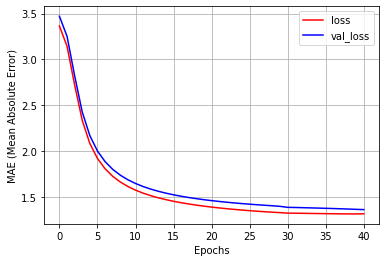

In [13]:
plt.plot(MF.history['epochs'], MF.history['loss'], 'r', label="loss")
plt.plot(MF.history['epochs'], MF.history['val_loss'], 'b', label="val_loss")
plt.legend(loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("MAE (Mean Absolute Error)")
plt.grid(True)
plt.show()

In [14]:
MF.evaluate(X_test, y_test)

val_error :  1.361


Now that the latent factors $P$ and $Q$, we can use them to make predictions and recommendations. Let's call the ```predict``` function of the ```Matrix Factorization``` class to make prediction for a given.

rating prediction for user 1 on item 6 for which the truth rating $r=4.0$

In [15]:
MF.predict(userid=1, itemid=6)

4.269817544036902

Now we can make recommendations for a  given user with function ```recommend``` of the ```Matrix Factorization``` class.

In [16]:
# get list of top N items with their corresponding predicted ratings
recommended_items, predictions = MF.recommend(userid=42)

# find corresponding movie titles
top_N = list(zip(recommended_items,predictions))
top_N = pd.DataFrame(top_N, columns=['itemid','predictions'])
List = pd.merge(top_N, movies, on='itemid', how='inner')

# show the list
List

,itemid,predictions,title
0,97194,5.436833,"Thing: Terror Takes Shape, The (1998)"
1,71033,4.993889,"Secret in Their Eyes, The (El secreto de sus o..."
2,7065,4.973198,"Birth of a Nation, The (1915)"
3,8464,4.883735,Super Size Me (2004)
4,92259,4.812528,Intouchables (2011)
5,1203,4.643011,12 Angry Men (1957)
6,5444,4.627319,Lilo & Stitch (2002)
7,6016,4.597095,City of God (Cidade de Deus) (2002)
8,335,4.519516,Underneath (1995)
9,54286,4.464704,"Bourne Ultimatum, The (2007)"


**Note**: The recommendation list may content items already purchased by the user. This is just an illustration of how to implement matrix factorization recommender system. You can optimize the recommended list and return the top rated items that the user has not already purchased.

## Reference

1. Yehuda Koren et al. (2009). <a href='https://ieeexplore.ieee.org/document/5197422'>Matrix Factorization Techniques for Recommender Systems</a>

## Author

<a href="https://www.linkedin.com/in/carmel-wenga-871876178/">Carmel WENGA</a>, Applied Machine Learning Research Engineer | <a href="https://shoppinglist.cm/fr/">ShoppingList</a>, Nzhinusoft